In [53]:
import requests
import json
import time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve, recall_score
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from scipy import stats
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
from datetime import datetime
import pandas_profiling as pdp
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
from jupyterthemes import jtplot
import geopy.distance
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA

output_notebook()
jtplot.style()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Loading BokehJS ...

In [2]:
df = pd.read_csv('/Users/saqibnizami/notebooks/DSI-US-4/Projects/project-4/input/train.csv')
weather = pd.read_csv('/Users/saqibnizami/notebooks/DSI-US-4/Projects/project-4/input/weather.csv')
spray = pd.read_csv('/Users/saqibnizami/notebooks/DSI-US-4/Projects/project-4/input/spray.csv')
test = pd.read_csv('/Users/saqibnizami/notebooks/DSI-US-4/Projects/project-4/input/test.csv')

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [7]:
pdp.ProfileReport(df)

Number of variables,12
Number of observations,10506
Total Missing (%),0.0%
Total size in memory,985.0 KiB
Average record size in memory,96.0 B
Numeric,5
Categorical,6
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [12]:

pdp.ProfileReport(test)

Number of variables,11
Number of observations,116293
Total Missing (%),0.0%
Total size in memory,9.8 MiB
Average record size in memory,88.0 B
Numeric,5
Categorical,6
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [8]:
def clean_train_data(df):
    
    # map df dataset with weather dataset
    mask3 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) <= \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    mask4 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) > \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    df.loc[mask3,'weather_station'] = 1
    df.loc[mask4,'weather_station'] = 2
    df_weather = df.join(weather.set_index(['Date','Station']), on=(['Date','weather_station']), how='left')
    
    # map df_weather dataset with spray dataset
    date_format = "%Y-%m-%d"
    date_formated_df = []
    date_formated_spray = []
    for i in df_weather['Date']:
        date_formated_df.append(datetime.strptime(i, date_format))
    for i in spray['Date']:
        date_formated_spray.append(datetime.strptime(i, date_format))
    date_formated_spray = set(date_formated_spray)
    date_formated_spray = list(date_formated_spray)
    days_after_spray = []
    for i in date_formated_df:
        delta = []
        for n in date_formated_spray:
            if (i - n).days > 0:
                delta.append((i - n).days)
        if len(delta) != 0:
            days = np.min(delta)
        else:
            days = 0
        days_after_spray.append(days)
    df_weather['days_after_spray'] = days_after_spray
    
    # clean up the total dataset 
    df_total = df_weather
    
    #create ordinal date column
    df_total['Date'] = pd.to_datetime(df_total['Date'])
    df_total['ordinal_date'] = df_total['Date'].map(lambda x: x.toordinal())
    
    ## drop useless columns
    ## different for train and test dataset because test data doesn't include 'NumMosquitos' column
    ## and test data has "Id" column that need to be dropped
    
    df_total = df_total.drop(['Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
              'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
              'Water1','SnowFall', 'Sunrise', 'Sunset'],axis=1)
              # NumMosquitos and CodeSum may still helpful (test data doesn't include 'NumMosquitos' column)
              #**changed this to keep NumMosquitos
    
    ## deal with the missing value of the useful columns
    mask5 = (df_total.PrecipTotal == '  T')| (df_total.PrecipTotal =='M')
    mask6 = df_total.WetBulb == 'M'
    mask7 = df_total.StnPressure == 'M'
    df_total.loc[mask5,'PrecipTotal'] = 0.00
    df_total.loc[mask6,'WetBulb'] = round((df_total[df_total.WetBulb!='M']['WetBulb']).astype('int').mean())
    df_total.loc[mask7,'StnPressure'] = round((df_total[df_total.StnPressure!='M']['StnPressure']).astype('float').mean(),2)
    
    ## change the datatype to correct one
    df_total[['Tavg','WetBulb','Heat','Cool']] = df_total[['Tavg','WetBulb','Heat','Cool']].astype(int)
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']] = \
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']].astype(float)
    
    #computer rolling averages 
    for i in [3,5,10,14,21]: #set intervals for rolling average calculation
        for j in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',    #columns to compute rolling averages for
                  'PrecipTotal', 'StnPressure', 'SeaLevel','ResultSpeed', 'ResultDir', 'AvgSpeed']:
            df_total[j + str(i)] = df_total[j].rolling(window=i, min_periods=int(i/5)).mean() #create column with interval for each computation
                                                                                #min_periods allows for computing these and not getting NaN values
                                                                                #for reasonable amount of missing data
    
    #fill na's
    df_total.fillna(method='backfill', inplace=True)
    
    ## dummy the object variable
    df_total = pd.get_dummies(df_total,drop_first=True,columns=['Species'])
    
    # return cleaned dataframe

    return df_total

In [9]:
def clean_test_data(df):
    
    # map df dataset with weather dataset
    mask3 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) <= \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    mask4 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) > \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    df.loc[mask3,'weather_station'] = 1
    df.loc[mask4,'weather_station'] = 2
    df_weather = df.join(weather.set_index(['Date','Station']), on=(['Date','weather_station']), how='left')

    # map df_weather dataset with spray dataset
    date_format = "%Y-%m-%d"
    date_formated_df = []
    date_formated_spray = []
    for i in df_weather['Date']:
        date_formated_df.append(datetime.strptime(i, date_format))
    for i in spray['Date']:
        date_formated_spray.append(datetime.strptime(i, date_format))
    date_formated_spray = set(date_formated_spray)
    date_formated_spray = list(date_formated_spray)
    days_after_spray = []
    for i in date_formated_df:
        delta = []
        for n in date_formated_spray:
            if (i - n).days > 0:
                delta.append((i - n).days)
        if len(delta) != 0:
            days = np.min(delta)
        else:
            days = 0
        days_after_spray.append(days)
    df_weather['days_after_spray'] = days_after_spray
    
    # clean up the total dataset 
    df_total = df_weather
    
    #create ordinal date column
    df_total['Date'] = pd.to_datetime(df_total['Date'])
    df_total['ordinal_date'] = df_total['Date'].map(lambda x: x.toordinal())
    
    ## drop useless columns
    ## different for train and test dataset because test data doesn't include 'NumMosquitos' column
    ## and test data has "Id" column that need to be dropped
    
    ### for train dataset
#     df_total = df_total.drop(['Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
#               'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
#               'Water1','SnowFall','Sunrise','Sunset','NumMosquitos'],axis=1)
                 
                 # NumMosquitos and CodeSum may still helpful (test data doesn't include 'NumMosquitos' column)
    
    ### for test dataset
    df_total = df_total.drop(['Id','Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
               'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
               'Water1','SnowFall','Sunrise','Sunset'],axis=1)
    
    
    ## deal with the missing value of the useful columns
    mask5 = (df_total.PrecipTotal == '  T')| (df_total.PrecipTotal =='M')
    mask6 = df_total.WetBulb == 'M'
    mask7 = df_total.StnPressure == 'M'
    df_total.loc[mask5,'PrecipTotal'] = 0.00
    df_total.loc[mask6,'WetBulb'] = round((df_total[df_total.WetBulb!='M']['WetBulb']).astype('int').mean())
    df_total.loc[mask7,'StnPressure'] = round((df_total[df_total.StnPressure!='M']['StnPressure']).astype('float').mean(),2)
    
    ## change the datatype to correct one
    df_total[['Tavg','WetBulb','Heat','Cool']] = df_total[['Tavg','WetBulb','Heat','Cool']].astype(int)
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']] = \
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']].astype(float)
    
    #computer rolling averages 
    for i in [3,5,10,14,21]: #set intervals for rolling average calculation
        for j in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',    #columns to compute rolling averages for
                  'PrecipTotal', 'StnPressure', 'SeaLevel','ResultSpeed', 'ResultDir', 'AvgSpeed']:
            df_total[j + str(i)] = df_total[j].rolling(window=i, min_periods=int(i/5)).mean() #create column with interval for each computation
                                                                                #min_periods allows for computing these and not getting NaN values
                                                                                #for reasonable amount of missing data
    #fill na's
    df_total.fillna(method='backfill', inplace=True)
    
    ## dummy the object variable
    df_total = pd.get_dummies(df_total,drop_first=True,columns=['Species'])
    
    ## drop one of the dummy variable 'Species_UNSPECIFIED CULEX' that train dataset doesn't have
    df_total = df_total.drop(['Species_UNSPECIFIED CULEX'],axis=1)
    
    # create polynomial features
    
    ## for train dataset
#     y = df_total['WnvPresent']
#     X = df_total.drop('WnvPresent',axis=1)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.15)
#     poly = PolynomialFeatures(include_bias=False,degree=2)
#     X_train_poly = poly.fit_transform(X_train)
#     X_test_poly = poly.transform(X_test)
#     X_train=pd.DataFrame(X_train_poly,columns=poly.get_feature_names(X_train.columns))
#     X_test=pd.DataFrame(X_test_poly,columns=poly.get_feature_names(X_test.columns))
    
    ## for test dataset
#     poly = PolynomialFeatures(include_bias=False,degree=2)
#     df_total_poly = poly.fit_transform(df_total)
#     df_total=pd.DataFrame(df_total_poly,columns=poly.get_feature_names(df_total.columns))
    
    # return cleaned dataframe
    
    ## for train dataset, return X_train and X_test data
#     return X_train, X_test
    
    ## for test dataset, return df_total
    return df_total

In [10]:
test_clean = clean_test_data(test)
test_clean.shape

(116293, 88)

In [11]:
train_clean = clean_train_data(df)
train_clean.shape

(10506, 90)

In [12]:
train_clean['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [13]:
pdp.ProfileReport(train_clean)

Number of variables,90
Number of observations,10506
Total Missing (%),0.0%
Total size in memory,6.8 MiB
Average record size in memory,678.0 B
Numeric,14
Categorical,0
Boolean,7
Date,0
Text (Unique),0
Rejected,69


In [36]:
train_clean.columns.values, test_clean.columns.values

(array(['Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'Tmax',
        'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
        'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
        'ResultDir', 'AvgSpeed', 'days_after_spray', 'ordinal_date',
        'Tmax3', 'Tmin3', 'Tavg3', 'DewPoint3', 'WetBulb3', 'Heat3',
        'Cool3', 'PrecipTotal3', 'StnPressure3', 'SeaLevel3',
        'ResultSpeed3', 'ResultDir3', 'AvgSpeed3', 'Tmax5', 'Tmin5',
        'Tavg5', 'DewPoint5', 'WetBulb5', 'Heat5', 'Cool5', 'PrecipTotal5',
        'StnPressure5', 'SeaLevel5', 'ResultSpeed5', 'ResultDir5',
        'AvgSpeed5', 'Tmax10', 'Tmin10', 'Tavg10', 'DewPoint10',
        'WetBulb10', 'Heat10', 'Cool10', 'PrecipTotal10', 'StnPressure10',
        'SeaLevel10', 'ResultSpeed10', 'ResultDir10', 'AvgSpeed10',
        'Tmax14', 'Tmin14', 'Tavg14', 'DewPoint14', 'WetBulb14', 'Heat14',
        'Cool14', 'PrecipTotal14', 'StnPressure14', 'SeaLevel14',
        'ResultSpeed14', 'ResultDir14', 

## Saqib additions



In [ ]:
# train test split 
y = train_clean['WnvPresent']
X = train_clean.drop(['WnvPresent', 'NumMosquitos'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    random_state=42)

In [ ]:
# Using RandomForestClassifier
rfc = RandomForestClassifier(random_state=19)
bbc = BalancedBaggingClassifier(base_estimator=rfc,
                                random_state=10)

In [ ]:
bbc.fit(X_train,y_train)

In [ ]:
bbc_predict = bbc.predict(X_test)
bbc_score = recall_score(y_test, bbc_predict)

print ("BBC Test Score:", bbc_score)

In [ ]:
bbc_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, bbc_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
bbc_confusion

In [ ]:
bbc_params = {
    'n_estimators':np.arange(5,20),
    'warm_start': [True, False]
#     'max_samples': [1,2]
#     'max_features': np.arange(1,10)
}

In [54]:
bbc_gs = GridSearchCV(bbc,
                     param_grid=bbc_params,
                     scoring='recall',
                     cv = 10)

bbc_gs.fit(X_train,y_train)
bbc_gs_score = bbc_gs.score(X_test, y_test)

print("Best Params: ", bbc_gs.best_params_)
print ("BBC Test Score:", bbc_gs_score)

bbc_gs_predict = bbc_gs.predict(X_test)
bbc_gs_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, bbc_gs.predict(X_test))),
                         index = ['No WNV', 'WNV'],
                        columns=['Predicted no WNV','Predicted WNV'])
bbc_gs_confusion

BBC Test Score: 0.7101449275362319
Best Params:  {'n_estimators': 8, 'warm_start': True}
BBC Test Score: 0.6666666666666666


,Predicted no WNV,Predicted WNV
No WNV,1929,560
WNV,46,92


In [ ]:
pca = PCA(n_components=2)
pca.fit(tra)

In [28]:
len(bbc_gs_predict)

2627

In [29]:
sample = pd.read_csv('../project-4/input/sampleSubmission.csv')

In [30]:
len(sample)

116293

In [43]:
test_pred = bbc_gs.predict(test_clean)

In [44]:
test_pred.shape

(116293,)

In [45]:
test_pred = pd.DataFrame(test_pred)

In [46]:
test_pred['Id'] = [i for i in range(1,116294)]
test_pred['WnvPresent'] = test_pred[0]

In [47]:
test_pred.drop([0],axis=1,inplace=True)

In [48]:
test_pred.tail()

,Id,WnvPresent
116288,116289,0
116289,116290,0
116290,116291,0
116291,116292,0
116292,116293,0


In [49]:
test_pred['WnvPresent'].value_counts()

0    109592
1      6701
Name: WnvPresent, dtype: int64

In [50]:
test_pred.to_csv('test_pred_bbcgs.csv',index=False)

In [ ]:
# make a pipeline for bbc

In [52]:
train_clean.columns

Index(['Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'Tmax', 'Tmin',
       'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'days_after_spray', 'ordinal_date', 'Tmax3', 'Tmin3', 'Tavg3',
       'DewPoint3', 'WetBulb3', 'Heat3', 'Cool3', 'PrecipTotal3',
       'StnPressure3', 'SeaLevel3', 'ResultSpeed3', 'ResultDir3', 'AvgSpeed3',
       'Tmax5', 'Tmin5', 'Tavg5', 'DewPoint5', 'WetBulb5', 'Heat5', 'Cool5',
       'PrecipTotal5', 'StnPressure5', 'SeaLevel5', 'ResultSpeed5',
       'ResultDir5', 'AvgSpeed5', 'Tmax10', 'Tmin10', 'Tavg10', 'DewPoint10',
       'WetBulb10', 'Heat10', 'Cool10', 'PrecipTotal10', 'StnPressure10',
       'SeaLevel10', 'ResultSpeed10', 'ResultDir10', 'AvgSpeed10', 'Tmax14',
       'Tmin14', 'Tavg14', 'DewPoint14', 'WetBulb14', 'Heat14', 'Cool14',
       'PrecipTotal14', 'StnPressure14', 'SeaLevel14', 'ResultSpeed14',
       'ResultDir14', 'AvgSpeed14', 'Tmax21'

### upsample the dataset

In [14]:
# # upsample the minority df_total['WnvPresent'] == 1
# from sklearn.utils import resample

# ## Separate majority and minority classes
# df_majority = train_clean[train_clean.WnvPresent==0]
# df_minority = train_clean[train_clean.WnvPresent==1]
 
# ## Upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=9955,    # to match majority class
#                                  random_state=42) # reproducible results
 
# # Combine majority class with upsampled minority class
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# # Display new class counts
# df_upsampled.WnvPresent.value_counts()

1    9955
0    9955
Name: WnvPresent, dtype: int64

In [15]:
# sns.pairplot(df_upsampled)

In [16]:
# df_upsampled.info()

In [17]:
# plt.figure(figsize=(5,10))
# sns.heatmap(df_upsampled.corr()[['WnvPresent']],annot=True,cmap='bwr')
# plt.tight_layout()

### build the model

In [18]:
y = df_upsampled['WnvPresent']
X = df_upsampled.drop('WnvPresent',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.15)

In [19]:
# random forest is OK
pip1 = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
params1 = {
    'rf__n_estimators':[5,10,20],
    'rf__max_features': ["auto","sqrt","log2"],
    'rf__max_depth': [None,10,20]
}
gs1 = GridSearchCV(pip1, param_grid=params1)
gs1.fit(X_train, y_train)
print('best cv score', gs1.best_score_)
print('best paramas', gs1.best_params_)
print('test score', gs1.score(X_test, y_test))

best cv score 0.9654907522306919
best paramas {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__n_estimators': 10}
test score 0.9755607633076665


In [20]:
# create a confusion matrix
y_hat = gs1.predict(X_test)
confusion_matrix(y_test,y_hat)

array([[1430,   64],
       [   9, 1484]])

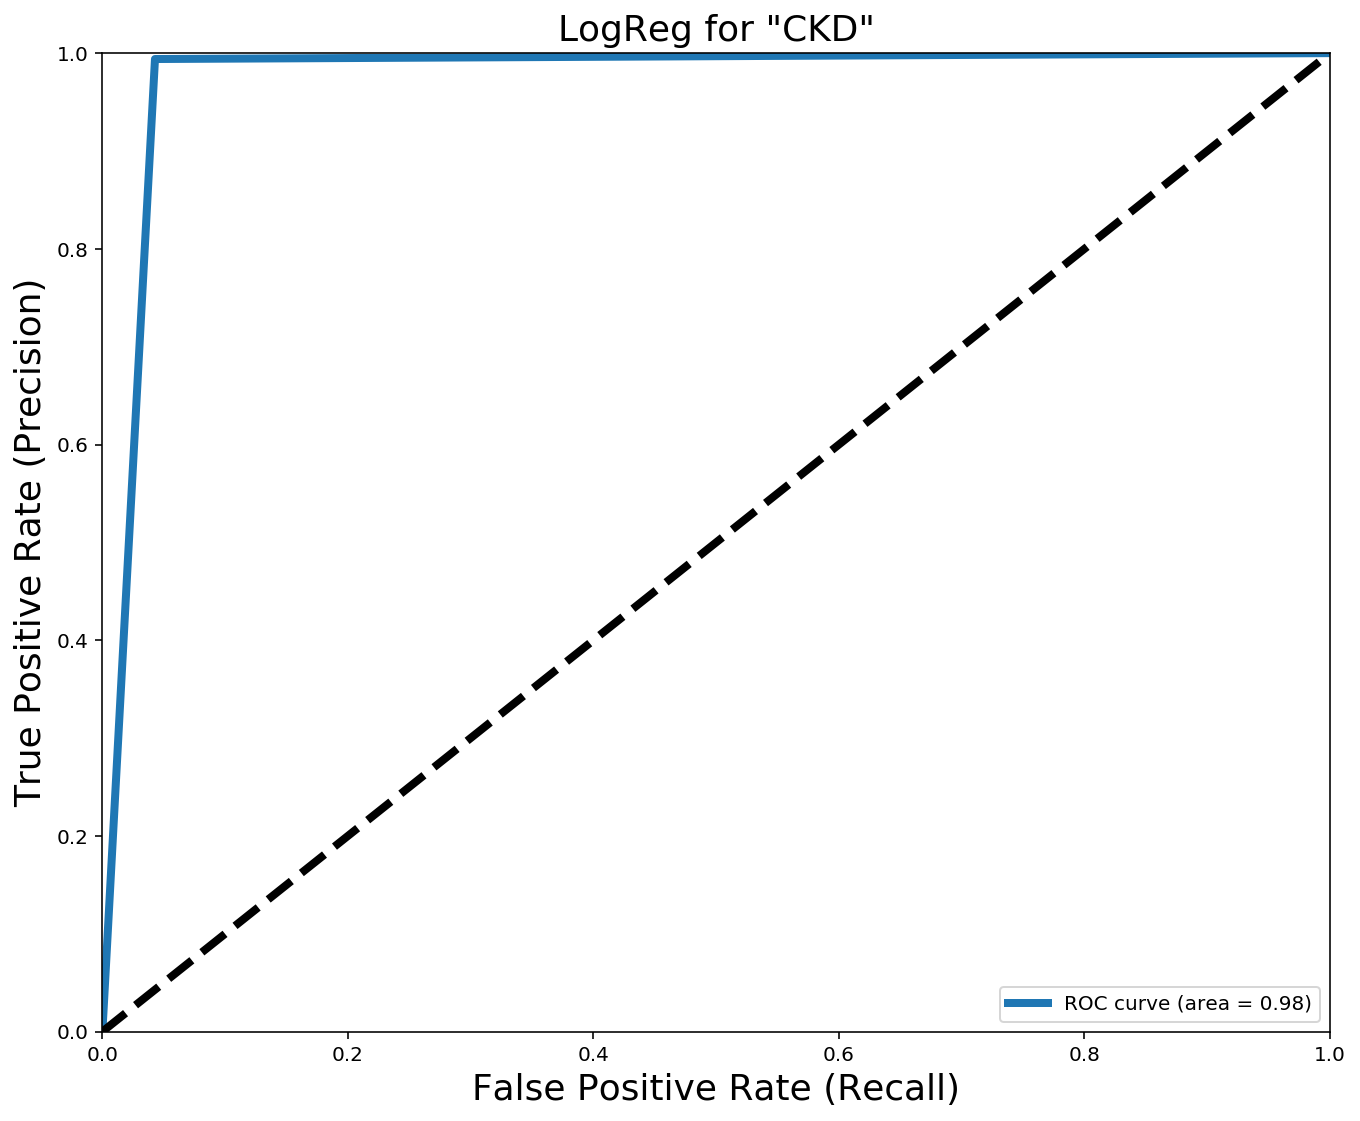

In [21]:
y_pred = gs1.predict(X_test)
FPR, TPR, threshold = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (Recall)', fontsize=18)
plt.ylabel('True Positive Rate (Precision)', fontsize=18)
plt.title('LogReg for "CKD"', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [ ]:
# svm
gamma_range = [0.001]
C_range = [1]
kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']

params3 = dict(gamma=gamma_range, kernel=kernel_range, C=C_range)

clf = svm.SVC()
gs3 = GridSearchCV(clf, params3, scoring="accuracy", verbose=0)
gs3.fit(X_train,y_train)

In [ ]:
print('best cv score', gs3.best_score_)
print('best paramas', gs3.best_params_)
print('test score', gs3.score(X_test, y_test))

In [ ]:
# svm using unbalanced sample and use class_weight = 'WnvPresent' to penalize mistakes on the minority class 
# by an amount proportional to how under-represented it is.
y = train_clean['WnvPresent']
X = train_clean.drop('WnvPresent',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)

gamma_range = [0.001]
C_range = [1]
kernel_range = ['linear']
class_weight=['balanced']

params4 = dict(gamma=gamma_range, kernel=kernel_range, C=C_range, class_weight=class_weight)

clf = svm.SVC()
gs4 = GridSearchCV(clf, params4, scoring="accuracy", verbose=0)
gs4.fit(X_train,y_train)

print('best cv score', gs4.best_score_)
print('best paramas', gs4.best_params_)
print('test score', gs4.score(X_test, y_test))

In [ ]:
# logistic regression is bad?
pip2 = Pipeline([
    ('ss', StandardScaler()), 
    ('lr', LogisticRegression())
])
params2 = {
    'lr__penalty':['l1','l2'],
    'lr__C':[0.1,0.5,0.9]
}
gs2 = GridSearchCV(pip2,param_grid=params2)
gs2.fit(X_train,y_train)
print('best cv score', gs2.best_score_)
print('best paramas', gs2.best_params_)
print('test score', gs2.score(X_test, y_test))

In [ ]:
# create a confusion matrix
y_hat = gs2.predict(X_test)
confusion_matrix(y_test,y_hat)

In [ ]:
# FFNN using Tensorflow
y = df_upsampled['WnvPresent']
X = df_upsampled.drop('WnvPresent',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
X_train.shape

In [ ]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None,X_train.shape[1]), name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name='y')

h1 = tf.layers.dense(X, 20, activation=tf.nn.relu, name='hidden1') # 20 features put into the layer
h2 = tf.layers.dense(h1, 20, activation=tf.nn.relu, name='hidden2')
h3 = tf.layers.dense(h2, 20, activation=tf.nn.relu, name='hidden3')
h4 = tf.layers.dense(h3, 20, activation=tf.nn.relu, name='hidden4')

y_hat = tf.layers.dense(h4, 1, activation=tf.nn.sigmoid, name='y_hat') # this is a binary classification problem

loss = tf.losses.log_loss(y, y_hat)
optimizer = tf.train.AdamOptimizer(.01) # adam do gradient descent: learning rate is little bit larger
training_run = optimizer.minimize(loss)

In [ ]:
saver = tf.train.Saver()

In [ ]:
init = tf.global_variables_initializer()
train_errs=[]
test_errs=[]
with tf.Session() as sess:
    init.run()
    for epoch in range(1000):
        sess.run(training_run, feed_dict={X: X_train, y: y_train})
        
        if epoch % 100 == 0:
            train_loss = sess.run(loss, feed_dict={X: X_train, y: y_train})
            train_errs.append(train_loss)
            test_loss = sess.run(loss, feed_dict={X: X_test, y: y_test})
            test_errs.append(test_loss)
            print('epoch', epoch, 'Train loss', train_loss, 'Test loss', test_loss)
    saver.save(sess, './Classfication.ckpt')

In [ ]:
# plot the learning curves
plt.plot(train_errs, label = 'Train loss')
plt.plot(test_errs, label = 'Test loss')
plt.legend()

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './Classfication.ckpt')
    pred = sess.run(y_hat, feed_dict={X:X_test}) # run the prediction layer

In [ ]:
classes = (pred > .947).astype(int)
metrics.accuracy_score(y_test, classes)

In [ ]:
metrics.confusion_matrix(y_test, classes)

In [ ]:
FPR, TPR, threshold = roc_curve(y_test, pred)
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (Recall)', fontsize=18)
plt.ylabel('True Positive Rate (Precision)', fontsize=18)
plt.title('LogReg for "CKD"', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Clean and Predict test data set

In [31]:
test_clean.shape

(116293, 88)

In [ ]:
test_pred = gs1.predict(test_clean)

In [ ]:
test_pred.shape

In [ ]:
test_pred = pd.DataFrame(test_pred)

In [ ]:
test_pred['Id'] = [i for i in range(1,116294)]
test_pred['WnvPresent'] = test_pred[0]

In [ ]:
test_pred.drop([0],axis=1,inplace=True)

In [ ]:
test_pred.tail()

In [ ]:
test_pred['WnvPresent'].value_counts()

In [ ]:
test_pred.to_csv('test_pred_2.csv',index=False)